###Librerie

In [ ]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#Elaborazioni

###Funzioni

In [ ]:
def rend(r,p):
  return np.sum(r.mean()*p)

In [ ]:
def dev(r,p):
  cov = r.cov()
  return np.sqrt(np.array(p).T @ cov @ p)

###Database

In [ ]:
tickers = ['SWDA.MI','EMG.MI','PHAU.MI']
percentuali = [.8,.12,.08]
prezzi = yf.download(tickers)['Adj Close']
prezzi = prezzi.reindex(tickers,axis=1)

[*********************100%%**********************]  3 of 3 completed


In [ ]:
#rendimenti = prezzi.pct_change(1).dropna()
rendimenti = np.log(prezzi/prezzi.shift(1)).dropna()

In [ ]:
pf_rend = rendimenti@percentuali

In [ ]:
rend(rendimenti,percentuali)

0.0003603793849894034

In [ ]:
dev(rendimenti,percentuali)

0.00827669269485783

###VaR e CVaR storico

In [ ]:
pf_rend=pf_rend*100

In [ ]:
var_level = [90,95,99]
var = pd.DataFrame()
for i in var_level:
  var.loc[i,"VaR"] = np.percentile(pf_rend,100-i)
  print(f"Value at risk giornaliero {i}% = {round(var.loc[i,'VaR'],2)}%")
  print(f"Value at risk mensile {i}% = {round(var.loc[i,'VaR']*np.sqrt(20),2)}%")
  print(f"Value at risk annuale {i}% = {round(var.loc[i,'VaR']*np.sqrt(252),2)}%")

Value at risk giornaliero 90% = -0.83%
Value at risk mensile 90% = -3.71%
Value at risk annuale 90% = -13.17%
Value at risk giornaliero 95% = -1.23%
Value at risk mensile 95% = -5.5%
Value at risk annuale 95% = -19.54%
Value at risk giornaliero 99% = -2.36%
Value at risk mensile 99% = -10.55%
Value at risk annuale 99% = -37.44%


In [ ]:
cvar = pd.DataFrame()
for i in var_level:
  cvar.loc[i,"CVaR"] = pf_rend[pf_rend<=var.loc[i,'VaR']].mean()
  print(f"Conditional value at risk giornaliero {i}% = {round(cvar.loc[i,'CVaR'],2)}%")
  print(f"Conditional value at risk mensile {i}% = {round(cvar.loc[i,'CVaR']*np.sqrt(20),2)}%")
  print(f"Conditional value at risk annuale {i}% = {round(cvar.loc[i,'CVaR']*np.sqrt(252),2)}%")

Conditional value at risk giornaliero 90% = -1.53%
Conditional value at risk mensile 90% = -6.84%
Conditional value at risk annuale 90% = -24.28%
Conditional value at risk giornaliero 95% = -2.06%
Conditional value at risk mensile 95% = -9.22%
Conditional value at risk annuale 95% = -32.72%
Conditional value at risk giornaliero 99% = -3.69%
Conditional value at risk mensile 99% = -16.48%
Conditional value at risk annuale 99% = -58.51%


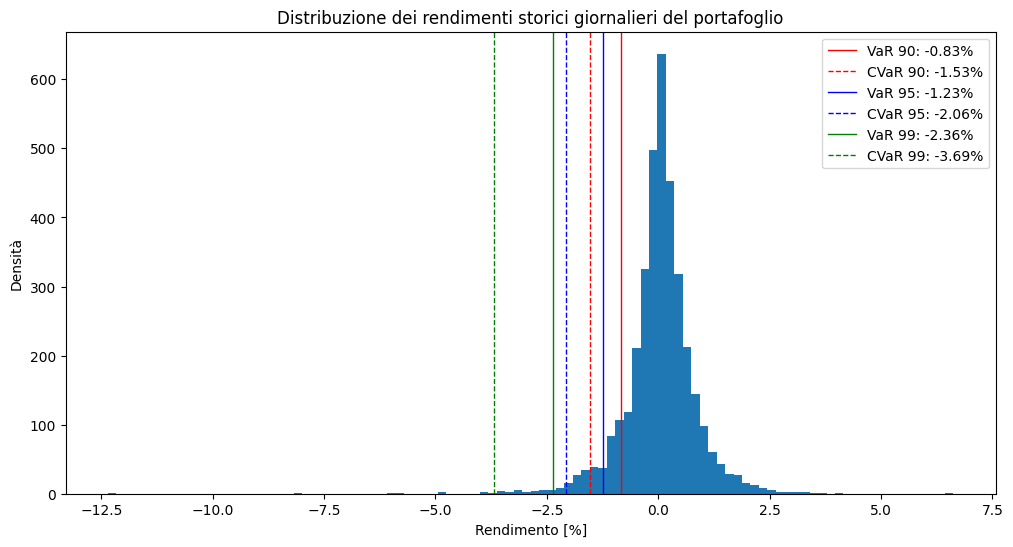

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(pf_rend,bins=100)
plt.grid(False)
plt.xlabel('Rendimento [%]')
plt.ylabel('Densità')
plt.axvline(var.iloc[0,0], color='r', linewidth=1, label=f'VaR 90: {round(var.iloc[0,0],2)}%')
plt.axvline(cvar.iloc[0,0], color='r', linestyle='--', linewidth=1, label=f'CVaR 90: {round(cvar.iloc[0,0],2)}%')
plt.axvline(var.iloc[1,0], color='b', linewidth=1, label=f'VaR 95: {round(var.iloc[1,0],2)}%')
plt.axvline(cvar.iloc[1,0], color='b', linestyle='--', linewidth=1, label=f'CVaR 95: {round(cvar.iloc[1,0],2)}%')
plt.axvline(var.iloc[2,0], color='g', linewidth=1, label=f'VaR 99: {round(var.iloc[2,0],2)}%')
plt.axvline(cvar.iloc[2,0], color='g', linestyle='--', linewidth=1, label=f'CVaR 99: {round(cvar.iloc[2,0],2)}%')
plt.legend()
plt.title('Distribuzione dei rendimenti storici giornalieri del portafoglio')
plt.show()

###VaR e CVaR parametrici

In [ ]:
intervalli_confidenza=[.1,.05,.01]
pvar = pd.DataFrame()
for i in intervalli_confidenza:
  pvar.loc[i,'VaR parametrico'] = norm.ppf(i,rend(rendimenti,percentuali),dev(rendimenti,percentuali))

In [ ]:
scaling_risk=pd.DataFrame(columns=intervalli_confidenza)
for i in intervalli_confidenza:
  for d in range(1,253):
    #scaling_risk.iloc[d,0] = pvar*np.sqrt(d)
    scaling_risk.loc[d,i] = pvar.loc[i,'VaR parametrico']*np.sqrt(d)

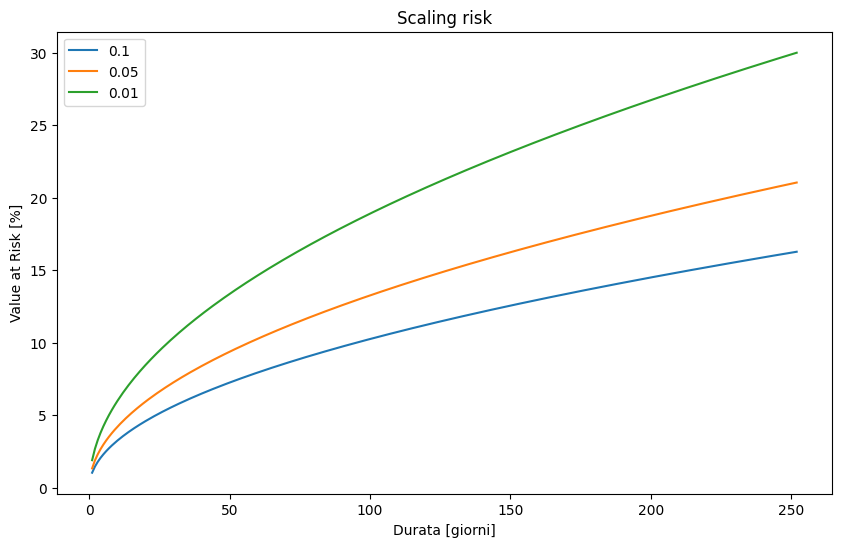

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(abs(scaling_risk*100),label=scaling_risk.columns)
plt.xlabel('Durata [giorni]')
plt.ylabel('Value at Risk [%]')
plt.title('Scaling risk')
plt.legend()
plt.show()

###Monte Carlo mio portafoglio

In [ ]:
iterazioni = 10000

In [ ]:
simulazione = pd.DataFrame(columns=['Rendimenti'])
pfrend = 7
pfdev = 10
for c in range(iterazioni):
  simulazione.loc[c,:]=(np.random.normal(pfrend,pfdev))

In [ ]:
var_99_fc = np.percentile(simulazione,1)
cvar_99_fc = simulazione[simulazione<=var_99_fc].mean()

In [ ]:
print(f'VaR 99: {round(var_99_fc,2)}%')

VaR 99: -16.25%


In [ ]:
print(f'CVaR 99: {round(float(cvar_99_fc),2)}%')

CVaR 99: -19.32%


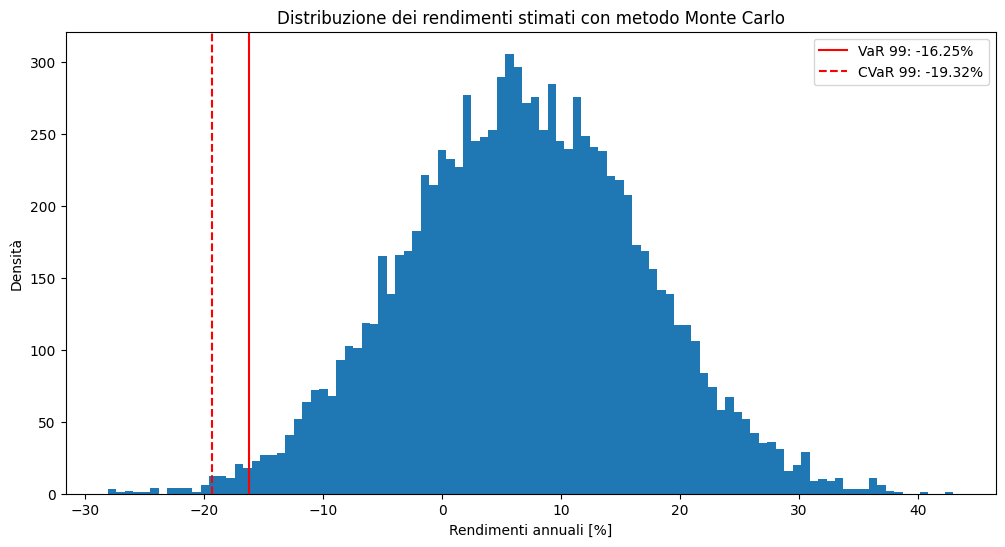

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(simulazione,bins=100)
plt.axvline(var_99_fc,color='r',label=f'VaR 99: {round(var_99_fc,2)}%')
plt.axvline(float(cvar_99_fc),color='r',linestyle='--',label=f'CVaR 99: {round(float(cvar_99_fc),2)}%')
plt.xlabel('Rendimenti annuali [%]')
plt.ylabel('Densità')
plt.legend()
plt.title('Distribuzione dei rendimenti stimati con metodo Monte Carlo')
plt.show()